# Self Organized Maps (SOMs) for EMU objects

Define the directory were all the files are saved.

In [4]:
observatory = '/data/mfonseca/'
my_computer = '/home/polaris/Lab_Astro/data/'

directory = my_computer

## Import Libraries

In [3]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import numpy as np
import pandas as pd

# SimpSOM, https://simpsom.readthedocs.io
import simpsom as sps

# Astropy
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u

# CuPY
# import cupy as cp

# Seaborn
import seaborn as sns

# Visualize Nans
import missingno

# Kolmorgorov-Smirnov
from scipy.stats import kstest

# Standardize data
from sklearn.preprocessing import StandardScaler

## PCA Whitening and ZPCA Whitening

[Link to Explanation](http://ufldl.stanford.edu/tutorial/unsupervised/PCAWhitening/)

[Link to Visualization](https://setosa.io/ev/principal-component-analysis/)

In [5]:
def pca_whitening(data, epsilon=1e-5):
    '''
    PCA whitening

    Args:
        data: array-like data
        epsilon: small value to avoid division by zero

    Returns:
        out: array-like data pca whitened
    
    '''
    # Data needs to have 0 mean
    data_mean = np.mean(data, axis=0)
    data_centered = data - data_mean

    # If the data has 0 mean, then we calculate the covariance matrix
    # rowvar=False means that each row is an observation
    cov_matrix = np.cov(data_centered, rowvar=False)

    # Calculate the eigenvalues and the eigenvectors
    eigvals, eigvecs = np.linalg.eigh(cov_matrix)

    # Sort the eigenvalues and eigenvectors
    idx = np.argsort(eigvals)[::-1]
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]

  
    D_inv_sqrt = np.diag(1.0 / np.sqrt(eigvals + epsilon))
    whitening_matrix = eigvecs @ D_inv_sqrt @ eigvecs.T

    xPCAwhite = (whitening_matrix @ data_centered.T).T

    return xPCAwhite


def zca_whitening(data, epsilon=1e-5):
    '''
    ZCA whitening
    
    Args:
        data: array-like data
        epsilon: small value to avoid division by zero

    Returns:
        out: array-like data zca whitened

    
    '''
    # Data needs to have 0 mean
    data_mean = np.mean(data, axis=0)
    data_mean0 = data - data_mean

    # If the data has 0 mean, then we calculate the covariance matrix
    # rowvar=False means that each row is an observation
    cov_matrix = np.cov(data_mean0, rowvar=False)

    # Calculate the eigenvalues and the eigenvectors
    eigvals, eigvecs = np.linalg.eigh(cov_matrix)

    # Sort the eigenvalues and eigenvectors
    idx = np.argsort(eigvals)[::-1]
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]

    # Calculate x_rot and x_tilde
    x_rot = np.dot(data_mean0, eigvecs)

    # Whitening matrix: U * D^{-1/2} * U.T
    D_inv_sqrt = np.diag(1.0 / np.sqrt(eigvals + epsilon))
    whitening_matrix = eigvecs @ D_inv_sqrt @ eigvecs.T

    # Apply whitening
    xZCAwhite = data_mean0 @ whitening_matrix
    
    return xZCAwhite

In [ ]:
def inverse_pca_whitening(original_data, whitened_data, epsilon=1e-5):
    '''
    Inverse PCA whitening

    Args:
        original_data: original data
        whitened_data: whitened data
        epsilon: small value to avoid division by zero

    Returns:
        out: array-like data in original feature space
    
    '''
    # Data needs to have 0 mean
    data_mean = np.mean(original_data, axis=0)
    data_centered = original_data - data_mean

    # If the data has 0 mean, then we calculate the covariance matrix
    # rowvar=False means that each row is an observation
    cov_matrix = np.cov(data_centered, rowvar=False)

    # Calculate the eigenvalues and the eigenvectors
    eigvals, eigvecs = np.linalg.eigh(cov_matrix)

    # Sort the eigenvalues and eigenvectors
    idx = np.argsort(eigvals)[::-1]
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]

    D_sqrt = np.diag(np.sqrt(eigvals + epsilon))

    # Calculate the inverse of the PCA whitening matrix
    X_centered = whitened_data @ ((eigvecs @ D_sqrt @ eigvecs.T))
    
    x_dewhitened = X_centered + data_mean.values

    return x_dewhitened


def inverse_zca_whitening(original_data, whitened_data, epsilon=1e-5):
    '''
    Inverse ZCA whitening
    
    Args:
        data: array-like data
        epsilon: small value to avoid division by zero

    Returns:
        out: array-like data in original feature space

    
    '''
    # Data needs to have 0 mean
    data_mean = np.mean(original_data, axis=0)
    data_mean0 = original_data - data_mean

    # If the data has 0 mean, then we calculate the covariance matrix
    # rowvar=False means that each row is an observation
    cov_matrix = np.cov(data_mean0, rowvar=False)

    # Calculate the eigenvalues and the eigenvectors
    eigvals, eigvecs = np.linalg.eigh(cov_matrix)

    # Sort the eigenvalues and eigenvectors
    idx = np.argsort(eigvals)[::-1]
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]

    # Calculate the inverse of the ZCA whitening matrix
    D = np.diag(np.sqrt(eigvals + epsilon))
    inverse_zca_matrix = eigvecs @ D @ eigvecs.T

    # Apply inverse transform and add mean back
    x_orig = (inverse_zca_matrix @ whitened_data.T).T + data_mean.values

    return x_orig


## Run the SOM

Import the matched catalog from NWAY and convert it to a Pandas DataFrame.

In [19]:
# RADIUS (3''), EMU (1''), DESY6GOLD (0.1''), VIKINGDR5 (0.1''), CATWISE2020 (0.2''), No MAGNITUDES
# For a false detection rate of <10% 
# p_i>=0.1 & match_flag==1 & p_any>0.83
matched_no_mags_path = directory + 'cross_match/EMU_0102-32_DESY6_VKG_CAT_fixed/EMU_0102-32_DESY6GOLD_VIKINGDR5_CATWISE_noMag.fits'
matched_no_mags = Table.read(matched_no_mags_path).filled()
matched_no_mags = matched_no_mags.to_pandas()

Filter using NWAY recomendations

In [24]:
# Here we filter the NWAY catalog to keep only the best objects

# From NWAY
# Filter the catalog based on the match_flag and p_i, p_any values
match_mask = (matched_no_mags['match_flag'] == 1) & (matched_no_mags['p_i'] >= 0.1) & (matched_no_mags['p_any'] >=0.69)
catalog_matches_noMags = matched_no_mags[match_mask]
print(f'Number of objects in the catalog {len(catalog_matches_noMags)}')

Number of objects in the catalog 9153


Select the objects that have matches in all the three surveys

In [27]:
# Here we select objects that have matches in all three surveys
full_match_mask = (catalog_matches_noMags['DESY6_coadd_object_id'] != -99) & (catalog_matches_noMags['VKG_sourceID'] == -99) & (catalog_matches_noMags['CAT_source_id'] == b'-99')
catalog_matches_noMags_full = catalog_matches_noMags[full_match_mask]

# Ignore the warning
catalog_matches_noMags_full['EMU_island_name'] = catalog_matches_noMags_full['EMU_island_name'].str.decode('utf-8').str.strip(' ')

print(f'Number of objects in the catalog that have matches in all three surveys {len(catalog_matches_noMags_full)}')

Number of objects in the catalog that have matches in all three surveys 165


/tmp/ipykernel_51842/3519432510.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  catalog_matches_noMags_full['EMU_island_name'] = catalog_matches_noMags_full['EMU_island_name'].str.decode('utf-8').str.strip(' ')


In [10]:
catalog_matches_noMags_full.drop(columns=['DESY6_mag_auto_y_extcorr', 'VKG_magerr_petro_z', 'VKG_mag_petro_z_ab_extcorr'], inplace=True)
catalog_matches_noMags_full.dropna(inplace=True)

print(len(catalog_matches_noMags_full))

catalog_matches_noMags_full_table = Table.from_pandas(catalog_matches_noMags_full)
catalog_matches_noMags_full_table.write('/home/polaris/Lab_Astro/data/cross_match/EMU_0102-32_DESY6GOLD_VIKING_CATWISE_noMags/EMU_0102-32_DESY6GOLD_VIKINGDR5_CATWISE_noMag_filtered.fits', format='fits', overwrite=True)

/tmp/ipykernel_38080/1238185098.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  catalog_matches_noMags_full.drop(columns=['DESY6_mag_auto_y_extcorr', 'VKG_magerr_petro_z', 'VKG_mag_petro_z_ab_extcorr'], inplace=True)
/tmp/ipykernel_38080/1238185098.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  catalog_matches_noMags_full.dropna(inplace=True)


3530


In [11]:
# Define the columns for the som

som_columns = ['DESY6_mag_auto_g_extcorr',
                   'VKG_mag_petro_y_ab_extcorr',
                   'CAT_w1mpro_ab',
                   'DESY6_g_r_extcorr', 
                   'DESY6_r_i_extcorr', 
                   'DESY6_i_z_extcorr', 
                   'VKG_y_j_petro_extcorr', 
                   'VKG_j_h_petro_extcorr', 
                   'VKG_h_ks_petro_extcorr', 
                   'CAT_w1_w2_ab', 
                   'DESY6_spread_model_g']


catalog_som = catalog_matches_noMags_full[som_columns]

In [12]:
# Remove rows with NaN values
catalog_som = catalog_som.dropna()

#missingno.matrix(catalog_som)
print(len(catalog_som))

catalog_som.describe()

3530


,DESY6_mag_auto_g_extcorr,VKG_mag_petro_y_ab_extcorr,CAT_w1mpro_ab,DESY6_g_r_extcorr,DESY6_r_i_extcorr,DESY6_i_z_extcorr,VKG_y_j_petro_extcorr,VKG_j_h_petro_extcorr,VKG_h_ks_petro_extcorr,CAT_w1_w2_ab,DESY6_spread_model_g
count,3530.000000,3530.000000,3530.000000,3530.000000,3530.000000,3530.000000,3530.000000,3530.000000,3530.000000,3530.000000,3530.000000
mean,21.987553,19.468605,18.608974,1.186201,0.660628,0.411460,0.270956,0.320992,0.307172,-0.251127,0.014807
std,2.044561,1.364588,0.799018,0.590204,0.327941,0.233515,0.285643,0.296840,0.306237,0.336535,0.025235
min,15.833063,14.605186,14.646999,-0.648590,-0.228563,-0.562861,-2.517520,-3.010494,-4.377286,-1.522001,-0.050804
25%,20.546523,18.594581,18.135000,0.806787,0.407556,0.274892,0.142343,0.183964,0.150878,-0.479000,0.008741
50%,22.201786,19.580910,18.650999,1.142556,0.591368,0.367965,0.246290,0.307818,0.281997,-0.297001,0.014861
75%,23.463618,20.504304,19.148750,1.523518,0.904924,0.496206,0.373039,0.451127,0.434128,-0.094999,0.020492
max,34.550007,23.194398,21.036999,10.291367,2.882668,1.457791,2.486458,3.055807,3.232750,1.243000,1.000000


In [141]:
# plt.figure(figsize=(8,8))
# plt.scatter(catalog_som['EMU_ra_deg_cont'], catalog_som['EMU_dec_deg_cont'], s=10, alpha=0.7)
# plt.xlabel('RA (deg)', size = 10)
# plt.ylabel('Dec (deg)', size = 10)
# plt.title('EMU objects that have a match in all three catalogs')
# plt.grid(True)
# plt.gca().invert_xaxis()  # Optional: invert RA to match sky convention
# plt.tight_layout()
# plt.show()

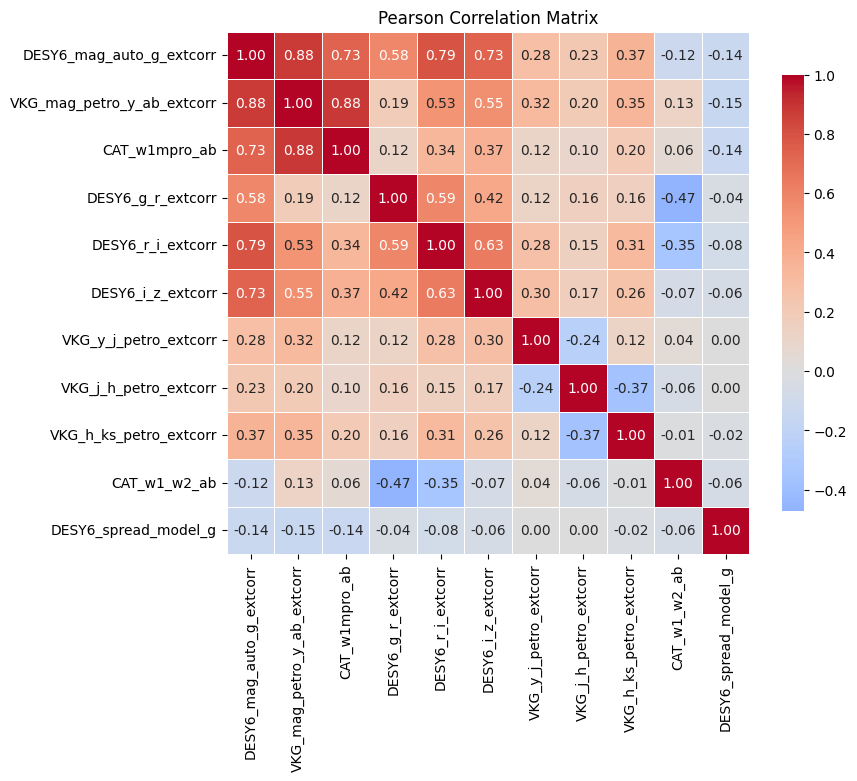

In [13]:
correlation_matrix = catalog_som.corr(method='pearson')
plt.figure(figsize = (9,8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0, square=True,
            linewidths=0.5, cbar_kws={"shrink": 0.75})

plt.title("Pearson Correlation Matrix")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [14]:
# Define the data fraction to use: important if its too much data
data_fraction2use = 1
data = catalog_som.sample(frac=data_fraction2use)

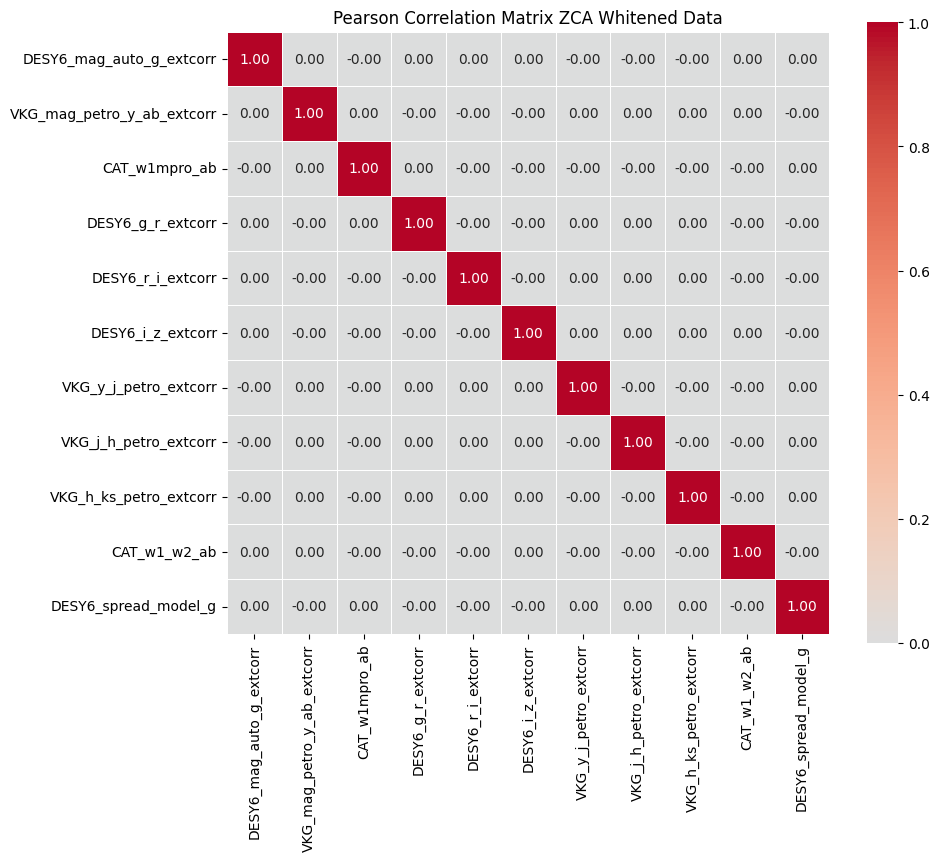

In [15]:
# Save the original data with id column and then remove it
data.columns = som_columns[:data.shape[1]]
data['id'] = catalog_matches_noMags_full['EMU_island_name']
data_path = '/home/polaris/Lab_Astro/data/soms/maps1/EMU_0102-32_DESY6GOLD_VIKINGDR5_CATWISE_noMag_original.csv'
data.to_csv(data_path, index=False)
data = data.drop(columns=['id'])



# Save whitened data with id column and then remove it
data_white = zca_whitening(data)
data_white.columns = som_columns[:data_white.shape[1]]
data_white['id'] = catalog_matches_noMags_full['EMU_island_name']
data_white_path = '/home/polaris/Lab_Astro/data/soms/maps1/EMU_0102-32_DESY6GOLD_VIKINGDR5_CATWISE_noMag_zcaWhite.csv'
data_white.to_csv(data_white_path, index=False)

# Remove the id column for the correlation matrix
data_white = data_white.drop(columns=['id'])


###############################################################################################################################
correlation_matrix = data_white.corr(method='pearson')
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0, square=True,
            linewidths=0.5, cbar_kws={"shrink": 0.75})

plt.title("Pearson Correlation Matrix ZCA Whitened Data")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### Define the SOM topology

In [16]:
data_white = np.array(data_white)

# If using unwhiten data, one needs to standardize it
data = np.array(data)
scaler = StandardScaler()
data_standardized = scaler.fit_transform(data)

# As a reference, to do the inverse we do
# data_unstandardized = scaler.inverse_transform(data_standardized)

In [17]:
# SOM topology (lattice size)
used_data = data_standardized

# Number of sources in our dataframe
inputdata_size = len(used_data)

# From Kohonen, the optimal ratio of height to width of the lattice
# is equal to the ratio of the two largest eigenvalue of the autocorrelation matrix
cov_matrix = np.cov(used_data, rowvar=False)
eigen_values = np.linalg.eigvals(cov_matrix)
eigen_values_sorted = np.sort(eigen_values)[::-1]
ratio_eigenvalues = eigen_values_sorted[0] / eigen_values_sorted[1]

# From Kohonen, the number of nodes is 5*sqrt(n), where n is the number of data points
som_dim = int(np.sqrt(inputdata_size) * 5)

# The number of nodes in the x and y direction
som_x = int(np.sqrt(som_dim * ratio_eigenvalues))
som_y = int(som_x / ratio_eigenvalues)

#=================================================================

# Resize the SOM map by applying a scaling factor that maintains the aspect ratio

scaling_factor = 2  # Change this factor to resize the map

# Apply scaling to the x dimension, and calculate y dimension based on ratio
som_x_resized = int(som_x * scaling_factor)
som_y_resized = int(som_x_resized / ratio_eigenvalues)  # Keep the same ratio of eigenvalues

#=================================================================

# Print the results
print('Dimension of the SOM: ', som_dim)
print('Square SOM map size ', np.round(np.sqrt(som_dim)))
print('Ratio of the two largest eigenvalues: ', int(ratio_eigenvalues))
print('SOM map size using eigenvalues: ', som_x, 'x', som_y)

print('Resized SOM map size using eigenvalues: ', som_x_resized, 'x', som_y_resized)

Dimension of the SOM:  297
Square SOM map size  17.0
Ratio of the two largest eigenvalues:  2
SOM map size using eigenvalues:  27 x 10
Resized SOM map size using eigenvalues:  54 x 21


### Run the SOM

In [35]:
# Define the SOM
som = sps.SOMNet(
    som_x,
    som_y,
    used_data,
    load_file = None,
    metric = 'euclidean', # 'euclidian' or 'cosine' or 'manhattan'
    # metrick_kwds={},
    init = 'random' , # 'random' or 'pca'
    PBC = True,
    GPU = False,
    random_seed = 470219,
    topology='hexagonal', # 'square' or 'hexagonal'
    debug= True,
    output_path = '/home/polaris/Lab_Astro/data/soms/maps4/epoch_files'
)

# Train the SOM
som.train(
    train_algo = 'batch', 
    epochs = 100,
    # start_learning_rate = 0.01 , # Used only for online training
    early_stop = None ,
    early_stop_patience = 3 ,
    early_stop_tolerance = 0.01 ,
    batch_size = -1
)

2025-05-22 12:51:37.387 | INFO     | simpsom.network:__init__:111 - Periodic Boundary Conditions active.
2025-05-22 12:51:37.389 | INFO     | simpsom.network:__init__:120 - Hexagonal topology.
2025-05-22 12:51:37.390 | INFO     | simpsom.network:_set_weights:196 - The weights will be initialized randomly.
2025-05-22 12:51:37.399 | INFO     | simpsom.network:train:469 - The map will be trained with the batch algorithm.
2025-05-22 12:51:37.652 | INFO     | simpsom.network:save_map:307 - Map shape and weights will be saved to:
/home/polaris/Lab_Astro/data/soms/maps4/epoch_files/trained_som_0epoch.npy
2025-05-22 12:51:37.922 | INFO     | simpsom.network:save_map:307 - Map shape and weights will be saved to:
/home/polaris/Lab_Astro/data/soms/maps4/epoch_files/trained_som_1epoch.npy
2025-05-22 12:51:38.173 | INFO     | simpsom.network:save_map:307 - Map shape and weights will be saved to:
/home/polaris/Lab_Astro/data/soms/maps4/epoch_files/trained_som_2epoch.npy
2025-05-22 12:51:38.418 | INF

/home/polaris/miniconda3/envs/labastro/lib/python3.10/site-packages/simpsom-3.0.0b0-py3.10.egg/simpsom/distances.py:178: RuntimeWarning: invalid value encountered in sqrt
  return self.xp.sqrt(squares_a + squares_b.T - 2 * a.dot(b.T))
2025-05-22 12:52:14.838 | INFO     | simpsom.network:get_nodes_difference:697 - Weights difference among neighboring nodes calculated.
/home/polaris/miniconda3/envs/labastro/lib/python3.10/site-packages/simpsom-3.0.0b0-py3.10.egg/simpsom/plots.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.set_ticklabels([f'{t:.3f}' for t in ticks])


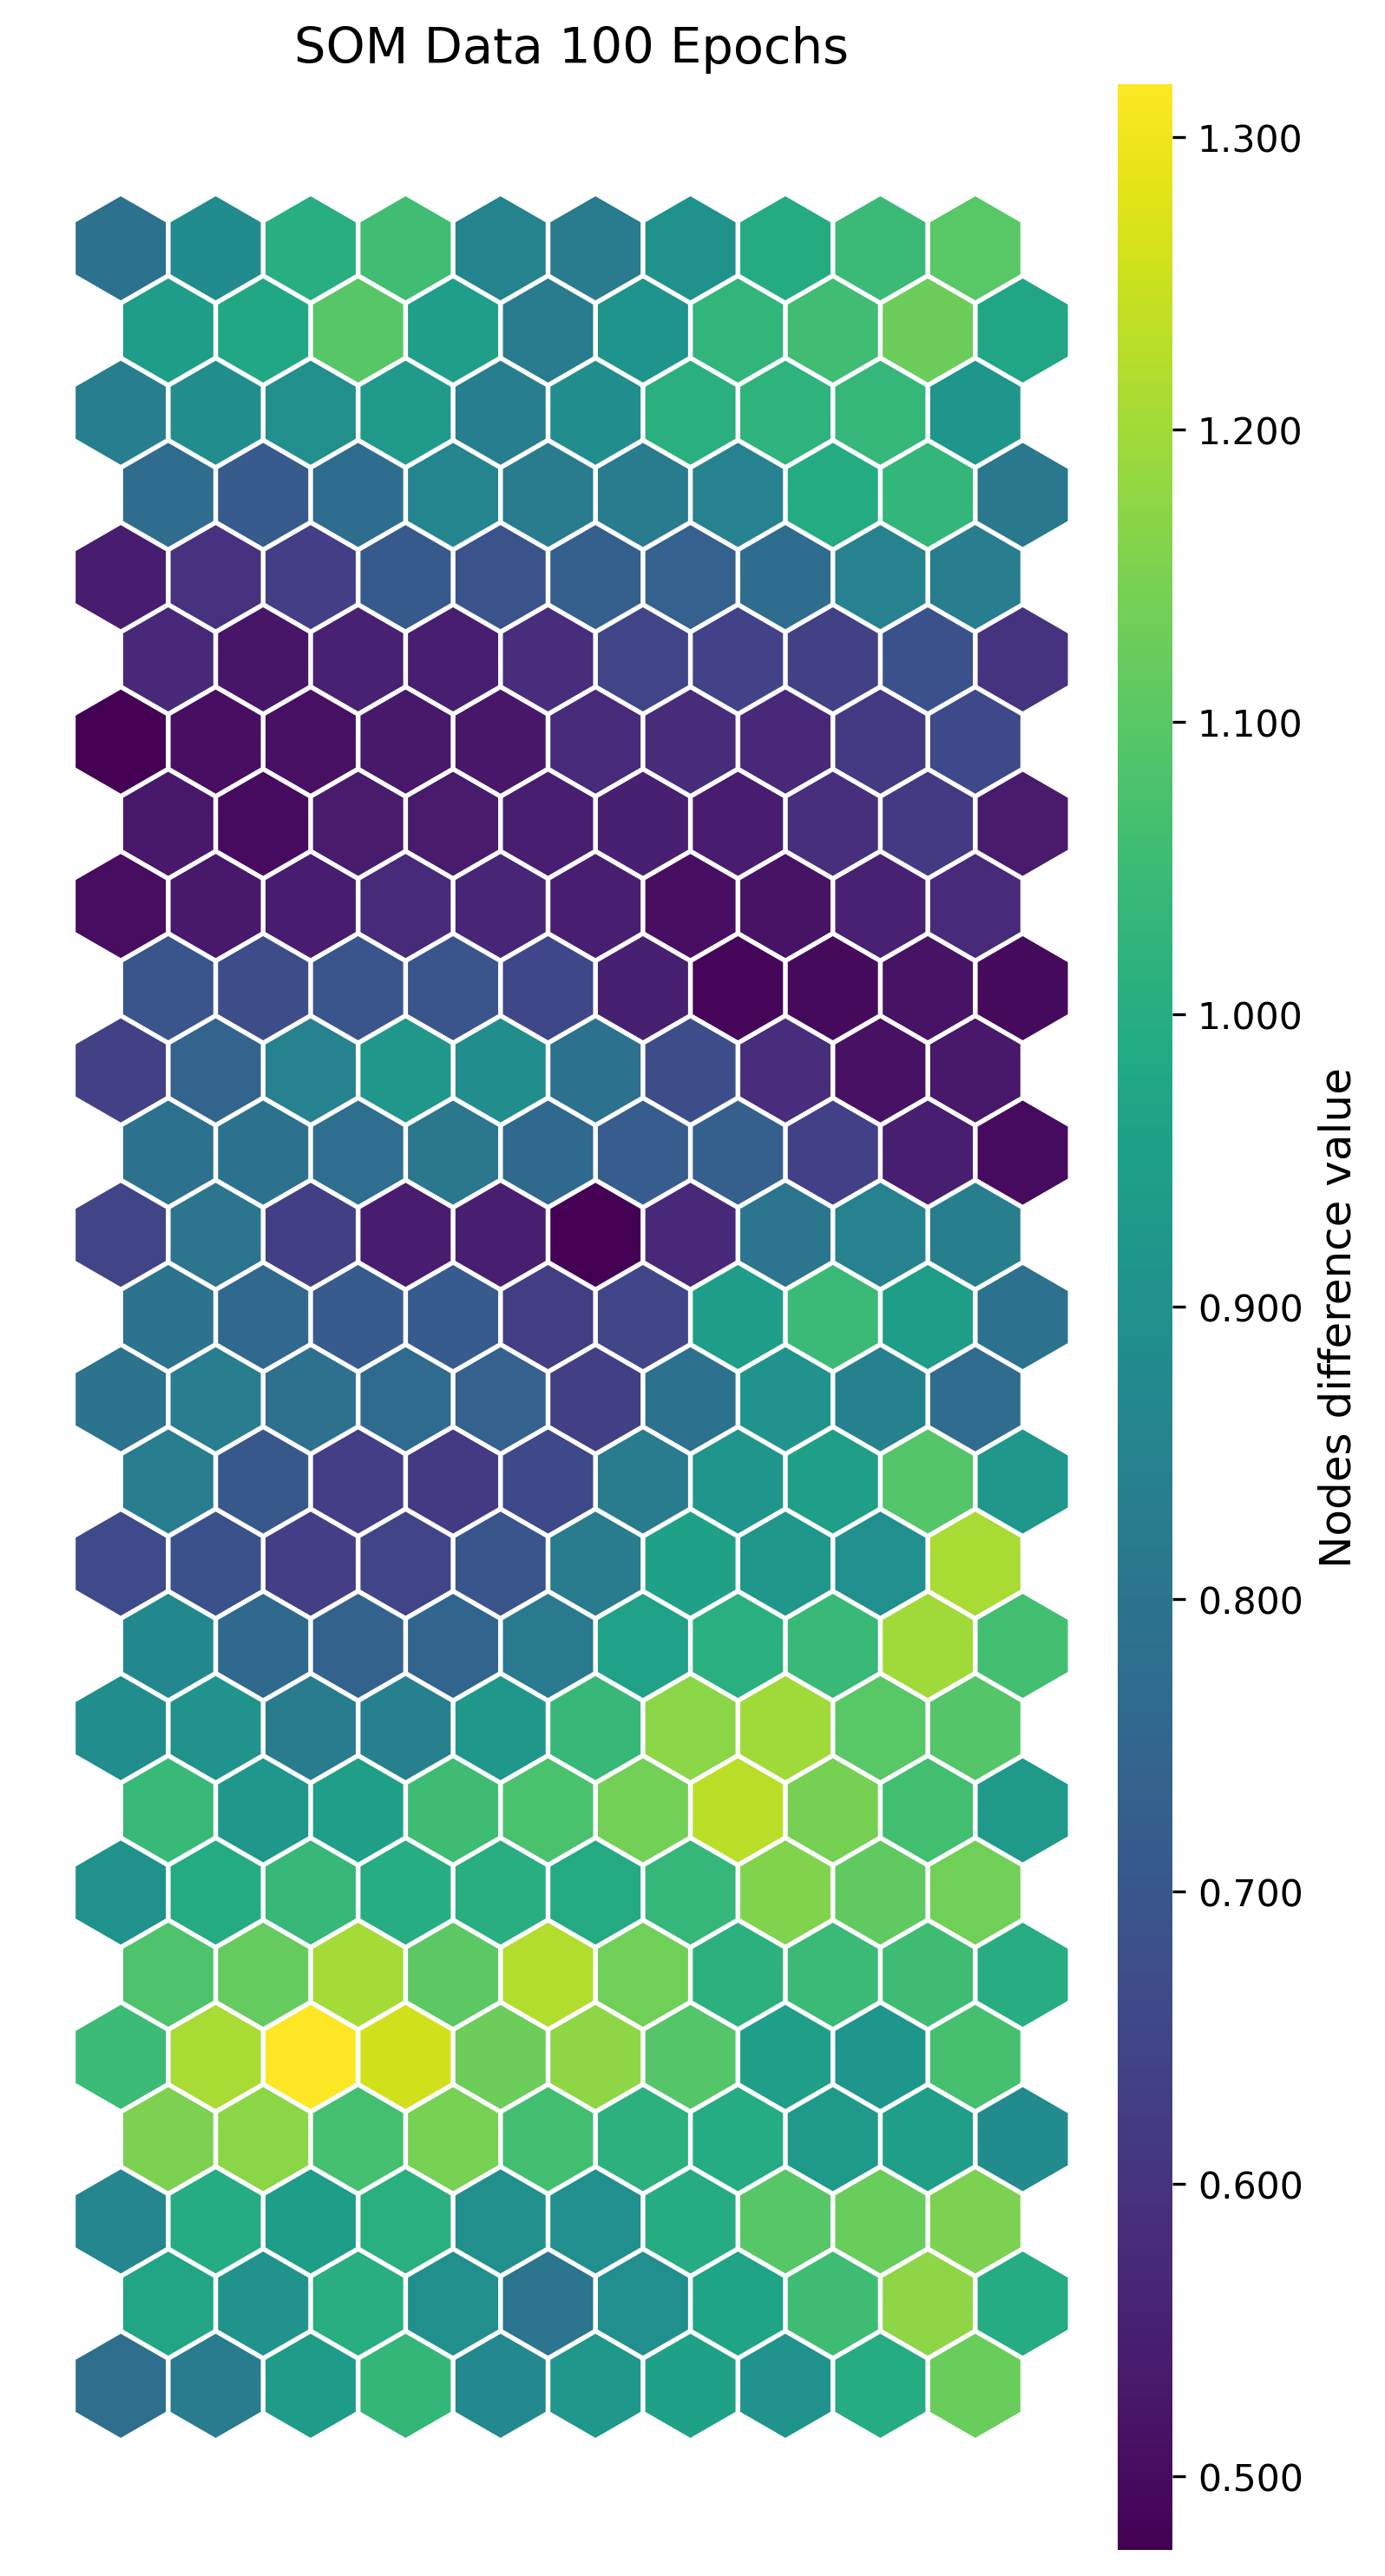

In [36]:
som.plot_map_by_difference(show=True, print_out=False, title='SOM Data 100 Epochs', figsize=(10,10))

## Quantization Error (QE) and Topographic Error (TE)

In [37]:
quantization_error=[]
topographic_error=[]


for i in range(0,98):
    name_file = directory + 'soms/maps4/epoch_files/trained_som_' + str(i) + 'epoch' + '.npy'
    
    # Define the SOM
    sommap = sps.SOMNet(
    som_x,
    som_y,
    used_data,
    load_file = name_file,
    debug= False,
    metric = 'euclidean',
    topology= 'hexagonal'
    )

    # Add errors to list
    quantization_error.append(sommap.calculate_qe(len(data)))
    topographic_error.append(sommap.calculate_te(len(data)))

# Print the errors
print('Quantization error: ', quantization_error)
print('Topographic error: ', topographic_error)

2025-05-22 12:52:19.827 | INFO     | simpsom.network:__init__:120 - Hexagonal topology.
2025-05-22 12:52:19.828 | INFO     | simpsom.network:_set_weights:201 - The weights will be loaded from file.
The map shape will be overwritten and no weightsinitialization will be applied.
2025-05-22 12:52:21.462 | INFO     | simpsom.network:__init__:120 - Hexagonal topology.
2025-05-22 12:52:21.463 | INFO     | simpsom.network:_set_weights:201 - The weights will be loaded from file.
The map shape will be overwritten and no weightsinitialization will be applied.
2025-05-22 12:52:22.639 | INFO     | simpsom.network:__init__:120 - Hexagonal topology.
2025-05-22 12:52:22.640 | INFO     | simpsom.network:_set_weights:201 - The weights will be loaded from file.
The map shape will be overwritten and no weightsinitialization will be applied.
2025-05-22 12:52:23.815 | INFO     | simpsom.network:__init__:120 - Hexagonal topology.
2025-05-22 12:52:23.816 | INFO     | simpsom.network:_set_weights:201 - The we

Quantization error:  [6.988377094268799, 2.802539348602295, 2.729452610015869, 2.699204921722412, 2.6853909492492676, 2.6750900745391846, 2.6654369831085205, 2.6553235054016113, 2.6451802253723145, 2.6345064640045166, 2.623811721801758, 2.6126441955566406, 2.601314067840576, 2.5896103382110596, 2.5775885581970215, 2.565389394760132, 2.552088499069214, 2.53899884223938, 2.523468255996704, 2.507993698120117, 2.49322772026062, 2.4792637825012207, 2.465059995651245, 2.45070743560791, 2.436079978942871, 2.421391248703003, 2.4061994552612305, 2.391023635864258, 2.375375509262085, 2.360045909881592, 2.3437530994415283, 2.328038215637207, 2.3110992908477783, 2.2950239181518555, 2.2774250507354736, 2.2609212398529053, 2.2425131797790527, 2.2248950004577637, 2.2046587467193604, 2.1863067150115967, 2.166776657104492, 2.1477394104003906, 2.129058361053467, 2.1105921268463135, 2.0924134254455566, 2.0742640495300293, 2.056670665740967, 2.0392658710479736, 2.0221941471099854, 2.0054094791412354, 1.98

[6.988377094268799, 2.802539348602295, 2.729452610015869, 2.699204921722412, 2.6853909492492676, 2.6750900745391846, 2.6654369831085205, 2.6553235054016113, 2.6451802253723145, 2.6345064640045166, 2.623811721801758, 2.6126441955566406, 2.601314067840576, 2.5896103382110596, 2.5775885581970215, 2.565389394760132, 2.552088499069214, 2.53899884223938, 2.523468255996704, 2.507993698120117, 2.49322772026062, 2.4792637825012207, 2.465059995651245, 2.45070743560791, 2.436079978942871, 2.421391248703003, 2.4061994552612305, 2.391023635864258, 2.375375509262085, 2.360045909881592, 2.3437530994415283, 2.328038215637207, 2.3110992908477783, 2.2950239181518555, 2.2774250507354736, 2.2609212398529053, 2.2425131797790527, 2.2248950004577637, 2.2046587467193604, 2.1863067150115967, 2.166776657104492, 2.1477394104003906, 2.129058361053467, 2.1105921268463135, 2.0924134254455566, 2.0742640495300293, 2.056670665740967, 2.0392658710479736, 2.0221941471099854, 2.0054094791412354, 1.9888465404510498, 1.972

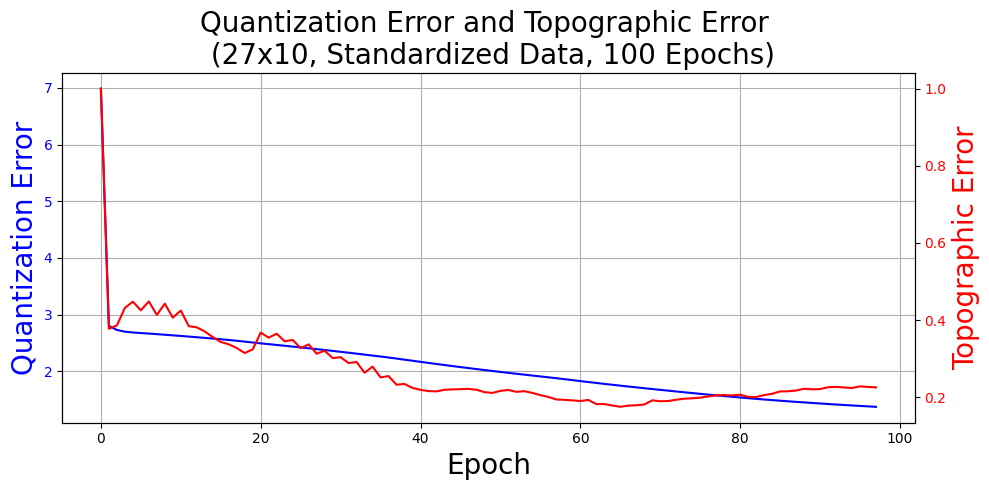

In [50]:
print(quantization_error)
print(topographic_error)

fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot Quantization Error on the primary y-axis
ax1.plot(quantization_error, label='Quantization Error', color='blue')
ax1.set_xlabel('Epoch', fontsize=20)
ax1.set_ylabel('Quantization Error', color='blue', fontsize=20)
ax1.tick_params(axis='y', labelcolor='blue')
ax1.tick_params(axis='x', labelcolor='black')
ax1.grid()

# Create a secondary y-axis for Topographic Error
ax2 = ax1.twinx()
ax2.plot(topographic_error, label='Topographic Error', color='red')
ax2.set_ylabel('Topographic Error', color='red', fontsize=20)
ax2.tick_params(axis='x', labelcolor='black')
ax2.tick_params(axis='y', labelcolor='red')

plt.title(f'Quantization Error and Topographic Error \n ({som_x}x{som_y}, Standardized Data, 100 Epochs)', fontsize=20)
fig.tight_layout()
plt.show()

Plot the uMatrix of the best epoch

## Prototypes

In [7]:
best_epoch = 81
best_som_path = directory + '/soms/maps4/epoch_files/trained_som_' + str(best_epoch) + 'epoch'+ '.npy'

# Define the SOM
best_som = sps.SOMNet(
    som_x,
    som_y,
    used_data,
    load_file = best_som_path,
    debug= False,
    )
best_som.plot_map_by_difference(show=True, print_out=False, title='SOM Data 80 Epochs', figsize=(10,10))

NameError: name 'som_x' is not defined

### Prototype Maps

In [1]:
all_positions = [[node.pos[0], node.pos[1]] for node in best_som.nodes_list]
all_weights = [[node.weights[feature_idx] for feature_idx in range(len(som_columns))] for node in best_som.nodes_list]

# convert back to the original feature space
weights_dewhitened = inverse_zpca_whitening(data, all_weights)

# Plot the dewhitned features
for idx in range(len(som_columns)):
    weights_dewhitened_feature = [weights_dewhitened[row][idx] for row in range(len(weights_dewhitened))]
    
    hexagon = sps.polygons.Hexagons

    sps.plots.plot_map(
        all_positions,
        weights_dewhitened_feature,
        hexagon,
        title = f'{som_columns[idx]}',
        show = False,
        print_out = True
    )

NameError: name 'best_som' is not defined

### Comparison of prototype values with original values

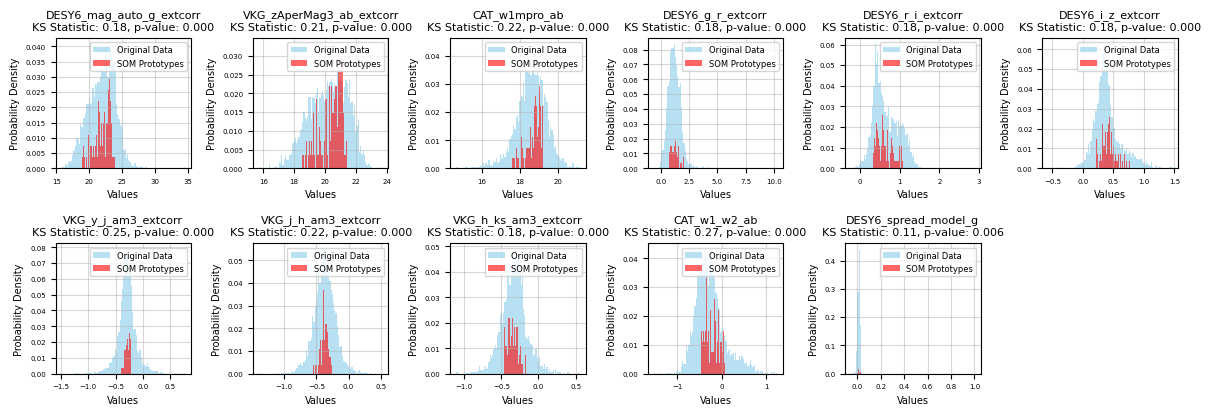

In [ ]:
num_cols = 6
num_rows = 3        
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, 6))
axes = axes.flatten()  # Flatten the 2D array of axes for easy indexing

for i, col in enumerate(som_columns):
    if i < len(axes):
        ax = axes[i]
        original_data = catalog_som[col]
        som_column_data = [weights_dewhitened[row][som_columns.index(col)] for row in range(len(weights_dewhitened))]

        # Histogram of the original data
        ax.hist(original_data, weights=np.ones(len(original_data)) / len(original_data), bins=100, alpha=0.6, label='Original Data', color='skyblue')

        # Histogram of the dewhitened prototypes
        ax.hist(som_column_data, weights=np.ones(len(som_column_data)) / len(som_column_data), bins=100, alpha=0.6, label='SOM Prototypes', color='red')

        # Kolmogorov-Smirnov test: how similar are the distributions?
        ks_statistic, p_value = kstest(original_data, som_column_data)
        ax.set_title(f'{col}\nKS Statistic: {ks_statistic:.2f}, p-value: {p_value:.3f}', fontsize=8)


        ax.set_xlabel('Values', fontsize=7)
        ax.set_ylabel('Probability Density', fontsize=7)
        ax.legend(fontsize=6)
        ax.grid(True, alpha=0.5)
        ax.tick_params(axis='both', which='major', labelsize=5)

# Removelast subplot
if len(som_columns) < len(axes):
    for j in range(len(som_columns), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Find the data points for each node

In [ ]:
# simpsom.network.SOMNode object at 'hexcode'
nodes = best_som.nodes_list

bmus = best_som.find_bmu_ix(data_white)

nodes_data_dict = {}

# Key= node object, Value = data index
for node in nodes:
    node_indices = [idx for idx in range(len(data_white)) if nodes[bmus[idx]] == node]
    nodes_data_dict[node] = node_indices

NameError: name 'best_som' is not defined

### Save the Galaxy Prototypes